# MCTS Log Analysis Notebook

This notebook parses your **FastLogger** logs produced by `main.py`, aggregates metrics across runs, and helps compare **MCTS parameter settings** (coverage, MSE, entropy) for different fields and start positions.

> **Setup:** Set `TRIALS_ROOT` below to the folder that contains your experiment folders (e.g., `/home/bota/Desktop/active_sensing_extended_planner/trials`).  
> The notebook is robust to both the **old** log row format and the **new** format that includes `Action` and `IG` columns.


In [1]:
import os, re, json
from pathlib import Path
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 🔧 SET THIS to your trials root (parent directory containing many run folders)
TRIALS_ROOT = os.environ.get(
    "TRIALS_ROOT", "/home/bota/Desktop/active_sensing_extended_planner/trials"
)

print("TRIALS_ROOT =", TRIALS_ROOT)


# Utility: safe float
def _to_float(x):
    try:
        return float(x)
    except Exception:
        return np.nan

TRIALS_ROOT = /home/bota/Desktop/active_sensing_extended_planner/trials


/home/bota/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
import json

header_re = {
    "strategy": re.compile(r"^Strategy:\s*(.+)\s*$", re.I),
    "pairwise": re.compile(r"^Pairwise:\s*(.+)\s*$", re.I),
    "n_agents": re.compile(r"^N agents:\s*(\d+)\s*$", re.I),
    "error": re.compile(r"^Error margin:\s*(.+)\s*$", re.I),
    "radius": re.compile(r"^Gaussian radius\s+([^\s]+)", re.I),
    "grid": re.compile(r"^Grid info:\s*(.+)$", re.I),
    "init": re.compile(r"^init UAV position:\s*(.+)$", re.I),
    "mcts_params": re.compile(r"^mcts_params:\s*(\{.*\})\s*$", re.I),
}

# Row formats
row_new = re.compile(
    r"^\s*(\d+)\s+([\d.eE+-]+)\s+([\d.eE+-]+)\s+([\d.eE+-]+)\s+([\d.eE+-]+)\s+(\S+)\s+([\d.eE+-]+|-)\s*$"
)
row_old = re.compile(
    r"^\s*(\d+)\s+([\d.eE+-]+)\s+([\d.eE+-]+)\s+([\d.eE+-]+)\s+([\d.eE+-]+)\s*$"
)
actions_line = re.compile(r"^actions:\s*(.*)$", re.I)


def parse_log_sections(text):
    """Yield sections: (header_dict, rows) where rows is list of dicts"""
    lines = text.splitlines()
    i = 0
    current = {"mcts_params": None}
    rows = []
    while i < len(lines):
        line = lines[i].rstrip()
        if header_re["strategy"].match(line):
            # flush previous
            if rows:
                yield current, rows
                rows = []
            # new header
            current = {"mcts_params": None}
            # read header block until table header 'Step'
            while i < len(lines) and not lines[i].lstrip().startswith("Step"):
                l = lines[i].rstrip()
                for k, rgx in header_re.items():
                    m = rgx.match(l)
                    if m:
                        if k == "mcts_params":
                            try:
                                current[k] = json.loads(m.group(1))
                            except Exception:
                                current[k] = None
                        else:
                            current[k] = m.group(1)
                i += 1
            # skip table header + delimiter
            while i < len(lines) and (
                lines[i].strip().lower().startswith("step")
                or set(lines[i].strip()) == set("-")
            ):
                i += 1
            continue
        # parse row
        m = row_new.match(line)
        if m:
            step, ent, mse, h, cov, act, ig = m.groups()
            rows.append(
                dict(
                    step=int(step),
                    entropy=_to_float(ent),
                    mse=_to_float(mse),
                    height=_to_float(h),
                    coverage=_to_float(cov),
                    action=None if act == "-" else act,
                    ig=None if ig == "-" else _to_float(ig),
                )
            )
        else:
            m2 = row_old.match(line)
            if m2:
                step, ent, mse, h, cov = m2.groups()
                rows.append(
                    dict(
                        step=int(step),
                        entropy=_to_float(ent),
                        mse=_to_float(mse),
                        height=_to_float(h),
                        coverage=_to_float(cov),
                        action=None,
                        ig=None,
                    )
                )
            # ignore 'actions: [...]' lines and other noise
        i += 1
    # flush last
    if rows:
        yield current, rows

In [3]:
from glob import glob


def extract_run_metadata(lp):
    """Extract metadata from log path."""
    trials_root = str(Path(lp).parents[3])
    run_base = Path(lp).parents[1].name
    if "__" in run_base:
        base_left, mcts_tag = run_base.split("__", 1)
    else:
        base_left, mcts_tag = run_base, None
    if "_" in base_left:
        field_type_lower, start_position = base_left.split("_", 1)
    else:
        field_type_lower, start_position = base_left, None
    field_type = (
        "Ortomap"
        if field_type_lower.lower() == "ortomap"
        else field_type_lower.capitalize()
    )
    return {
        "trials_root": trials_root,
        "run_base": run_base,
        "field_type": field_type,
        "start_position": start_position,
        "mcts_tag": mcts_tag,
    }


def extract_header_metadata(header):
    """Extract metadata from log section header."""
    corr = (header.get("pairwise") or "").strip() or None
    strategy = (header.get("strategy") or "").strip() or None
    e_margin = (header.get("error") or "").strip() or None
    n_agent = int(header.get("n_agents")) if header.get("n_agents") else None
    radius = (header.get("radius") or "").strip() or None
    mcts_params = header.get("mcts_params")
    mcts_params_str = json.dumps(mcts_params, sort_keys=True) if mcts_params else None
    return {
        "pairwise": corr,
        "strategy": strategy,
        "error_margin": e_margin,
        "n_agents": n_agent,
        "radius": radius,
        "mcts_params_str": mcts_params_str,
    }


def parse_log_file(lp):
    """Parse a single log file and return list of records."""
    records = []
    with open(lp, "r", errors="ignore") as f:
        text = f.read()
    meta = extract_run_metadata(lp)
    for header, rows in parse_log_sections(text):
        header_meta = extract_header_metadata(header)
        for r in rows:
            rec = dict(
                trials_root=meta["trials_root"],
                run_base=meta["run_base"],
                field_type=meta["field_type"],
                start_position=meta["start_position"],
                mcts_tag=meta["mcts_tag"],
                pairwise=header_meta["pairwise"],
                strategy=header_meta["strategy"],
                error_margin=header_meta["error_margin"],
                radius=header_meta["radius"],
                iter_idx=header_meta["n_agents"],
                step=r["step"],
                entropy=r["entropy"],
                mse=r["mse"],
                height=r["height"],
                coverage=r["coverage"],
                action=r["action"],
                ig=r["ig"],
                mcts_params=header_meta["mcts_params_str"],
                log_path=lp,
            )
            records.append(rec)
    return records


def collect_all_records(log_paths):
    """Collect records from all log files."""
    all_records = []
    for lp in log_paths:
        all_records.extend(parse_log_file(lp))
    return all_records

In [4]:
log_paths = glob(str(Path(TRIALS_ROOT) / "**" / "txt" / "run.log"), recursive=True)
print(f"Found {len(log_paths)} log files.")

records = collect_all_records(log_paths)
runs_df = pd.DataFrame.from_records(records)
print(runs_df.shape)
runs_df.head(1)

Found 63 log files.
(124251, 19)


,trials_root,run_base,field_type,start_position,mcts_tag,pairwise,strategy,error_margin,radius,iter_idx,step,entropy,mse,height,coverage,action,ig,mcts_params,log_path
0,/home/bota/Desktop/active_sensing_extended_pla...,ortomap_corner__mcts_pd5_ni25_uc1_df0.95_t5_p4,Ortomap,corner,mcts_pd5_ni25_uc1_df0.95_t5_p4,equal,mcts,0.1,orto,0,0,6507.85,0.226,19.5,0.0183,None,NaN,"{""discount_factor"": 0.95, ""num_iterations"": 25...",/home/bota/Desktop/active_sensing_extended_pla...


In [5]:
def canonical_label(row):
    # derive a short label from mcts_tag if present, else from params json string
    if row["strategy"] == "ig":
        return "ig"
    if row["strategy"] == "entropy_guided":
        return "entropy_guided"
    if row["mcts_tag"]:
        return row["mcts_tag"]
    if row["mcts_params"]:
        try:
            p = json.loads(row["mcts_params"])
            parts = [
                f"pd{p.get('planning_depth')}",
                f"ni{p.get('num_iterations')}",
                f"uc{p.get('ucb1_c')}",
                f"df{p.get('discount_factor')}",
                f"pa{p.get('parallel')}",
                f"to{p.get('timeout')}",
            ]
            return "mcts_" + "_".join([str(x) for x in parts if x is not None])
        except Exception:
            pass
    return "unknown"


def aggregate_runs(df):
    """Aggregate runs by key columns and compute mean/std of metrics."""

    df["setting_id"] = df.apply(canonical_label, axis=1)

    key_cols = [
        "field_type",
        "start_position",
        "pairwise",
        "strategy",
        "error_margin",
        "radius",
        "setting_id",
    ]

    agg = (
        df.groupby(key_cols + ["step"])  # aggregate over iterations
        .agg(
            entropy_mean=("entropy", "mean"),
            entropy_std=("entropy", "std"),
            mse_mean=("mse", "mean"),
            mse_std=("mse", "std"),
            coverage_mean=("coverage", "mean"),
            coverage_std=("coverage", "std"),
            height_mean=("height", "mean"),
            height_std=("height", "std"),
        )
        .reset_index()
    )
    return agg


agg = aggregate_runs(runs_df)

out_agg = Path("./data/mcts_agg.csv")
# agg.to_csv(out_agg, index=False)
# print("Saved:", out_agg)
agg.head()

,field_type,start_position,pairwise,strategy,error_margin,radius,setting_id,step,entropy_mean,entropy_std,mse_mean,mse_std,coverage_mean,coverage_std,height_mean,height_std
0,Gaussian,corner,equal,ig,0.1,4,ig,0,159581.6970,91.017525,0.2710,0.000000,0.003900,0.000000,5.40,0.000000
1,Gaussian,corner,equal,ig,0.1,4,ig,1,158752.8970,215.092754,0.2725,0.000688,0.015210,0.001744,10.53,1.207477
2,Gaussian,corner,equal,ig,0.1,4,ig,2,157569.0555,400.640100,0.2735,0.002065,0.029500,0.006682,13.50,3.277676
3,Gaussian,corner,equal,ig,0.1,4,ig,3,156062.1070,563.525927,0.2723,0.007533,0.044165,0.011405,14.60,4.700056
4,Gaussian,corner,equal,ig,0.1,4,ig,4,154374.7435,766.310491,0.2697,0.011712,0.057815,0.013497,14.60,4.700056


Selected settings: ['mcts_pd3_ni50_uc1_df0.95_t10_p4', 'mcts_pd5_ni50_uc0.5_df0.95_t10_p4', 'mcts_pd5_ni50_uc1.4_df0.95_t10_p4', 'mcts_pd5_ni50_uc0.9_df0.95_t10_p4', 'mcts_pd3_ni25_uc1_df0.95_t3_p8', 'mcts_pd5_ni50_uc1_df1_t10_p4', 'mcts_pd3_ni10_uc1_df0.95_t5_p1', 'mcts_pd5_ni75_uc0.9_df0.95_t15_p1', 'mcts_pd10_ni25_uc1_df0.95_t10_p4', 'mcts_pd5_ni25_uc1_df0.95_t5_p4', 'ig']


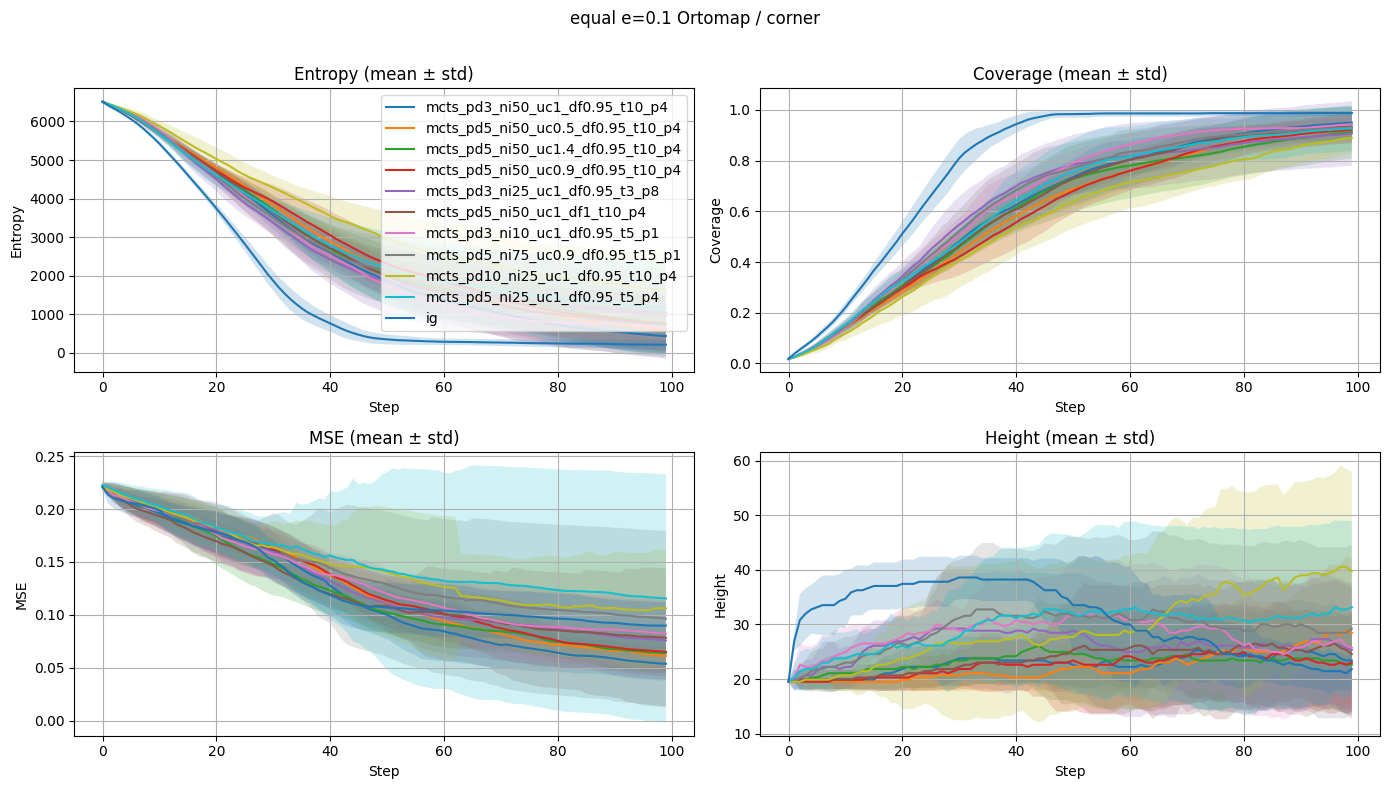

In [6]:
# Choose a slice for plotting
SLICE_FIELD = "Ortomap"  # "Ortomap" or "Gaussian"
SLICE_START = "corner"  # "corner" or "edge"
SLICE_PAIR = "equal"  # so far only "equal" tested
TOP_N = 20

# Always include 'ig' and 'entropy_guided'
ALWAYS_INCLUDE = ["ig", "entropy_guided"]

# Select only mcts-based strategies for ranking
mcts_sl = agg[
    (agg.field_type == SLICE_FIELD)
    & (agg.start_position == SLICE_START)
    & (agg.pairwise == SLICE_PAIR)
    & (agg.strategy == "mcts")
].copy()

# Rank mcts settings by final-step coverage
finals = mcts_sl.sort_values(["setting_id", "step"]).groupby("setting_id").tail(1)
ranked = finals.sort_values("mse_mean", ascending=True)
mcts_chosen = ranked.head(TOP_N).setting_id.tolist()

# Add ig and entropy_guided settings
extra_sl = agg[
    (agg.field_type == SLICE_FIELD)
    & (agg.start_position == SLICE_START)
    & (agg.pairwise == SLICE_PAIR)
    & (agg.strategy.isin(ALWAYS_INCLUDE))
].copy()
extra_settings = extra_sl["setting_id"].unique().tolist()

chosen = mcts_chosen + [sid for sid in extra_settings if sid not in mcts_chosen]
print("Selected settings:", chosen)

sl = agg[
    (agg.field_type == SLICE_FIELD)
    & (agg.start_position == SLICE_START)
    & (agg.pairwise == SLICE_PAIR)
    & (agg.setting_id.isin(chosen))
].copy()


def plot_runs(sl, chosen=None, title_suffix=""):
    """Plot the aggregated metrics for the chosen settings.
    sl is the sliced DataFrame.
    chosen is the list of setting_ids to plot. If None, plot all found in sl."""

    if chosen is None:
        chosen = sl["setting_id"].unique().tolist()

    fig, axs = plt.subplots(2, 2, figsize=(14, 8))
    metrics = [
        ("entropy_mean", "entropy_std", "Entropy (mean ± std)", axs[0, 0]),
        ("coverage_mean", "coverage_std", "Coverage (mean ± std)", axs[0, 1]),
        ("mse_mean", "mse_std", "MSE (mean ± std)", axs[1, 0]),
        ("height_mean", "height_std", "Height (mean ± std)", axs[1, 1]),
    ]

    for sid in chosen:
        d = sl[sl.setting_id == sid]
        x = d["step"].values

        for metric, err_metric, title, ax in metrics:
            y = d[metric].values
            if err_metric:
                yerr = d[err_metric].values
                ax.plot(x, y, label=sid)
                ax.fill_between(x, y - yerr, y + yerr, alpha=0.2)
            else:
                ax.plot(x, y, label=sid)
            ax.set_title(title)
            ax.set_xlabel("Step")
            if ax == axs[0, 0]:
                ax.legend()
            ax.grid(True)

    axs[0, 0].set_ylabel("Entropy")
    axs[0, 1].set_ylabel("Coverage")
    axs[1, 0].set_ylabel("MSE")
    axs[1, 1].set_ylabel("Height")

    if title_suffix:
        fig.suptitle(f"{title_suffix}\n" + f"equal e=0.1 {SLICE_FIELD} / {SLICE_START}")
    else:
        fig.suptitle(f"equal e=0.1 {SLICE_FIELD} / {SLICE_START}")
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


plot_runs(sl, chosen)

In [7]:
leader = ranked[
    [
        "setting_id",
        "coverage_mean",
        "coverage_std",
        "mse_mean",
        "mse_std",
        "entropy_mean",
        "entropy_std",
    ]
]
leader = leader.rename(
    columns={
        "coverage_mean": "final_coverage_mean",
        "coverage_std": "final_coverage_std",
        "mse_mean": "final_mse_mean",
        "mse_std": "final_mse_std",
        "entropy_mean": "final_entropy_mean",
        "entropy_std": "final_entropy_std",
    }
)
leader.head(20)

,setting_id,final_coverage_mean,final_coverage_std,final_mse_mean,final_mse_std,final_entropy_mean,final_entropy_std
3899,mcts_pd3_ni50_uc1_df0.95_t10_p4,0.949120,0.061702,0.05370,0.016040,430.6750,457.029059
4099,mcts_pd5_ni50_uc0.5_df0.95_t10_p4,0.928425,0.059672,0.06105,0.015244,601.4265,464.036849
4299,mcts_pd5_ni50_uc1.4_df0.95_t10_p4,0.911170,0.103681,0.06375,0.019257,747.7295,753.853859
4199,mcts_pd5_ni50_uc0.9_df0.95_t10_p4,0.921140,0.053214,0.06495,0.023549,751.2060,721.420377
3799,mcts_pd3_ni25_uc1_df0.95_t3_p8,0.906670,0.127175,0.07575,0.036779,957.3575,1118.036509
4399,mcts_pd5_ni50_uc1_df1_t10_p4,0.933890,0.049207,0.07835,0.065595,739.3080,777.571918
3699,mcts_pd3_ni10_uc1_df0.95_t5_p1,0.942835,0.041068,0.08225,0.033626,648.0170,586.767941
4499,mcts_pd5_ni75_uc0.9_df0.95_t15_p1,0.930880,0.053332,0.09630,0.082967,1043.8505,1166.893594
3599,mcts_pd10_ni25_uc1_df0.95_t10_p4,0.889780,0.062094,0.10610,0.055057,1632.4220,977.282416
3999,mcts_pd5_ni25_uc1_df0.95_t5_p4,0.926620,0.090371,0.11540,0.117607,1154.0995,1234.641225


## MSE as reward


In [8]:
scr_trials = "/home/bota/Desktop/active_sensing_extended_planner/gaussian_edge__mcts_pd5_ni50_uc0.95_df0.99_t20_p4"
reward_types = ["_global_MSE", "_local_MSE", "_IG"]
mse_reward_log_paths = [
    Path(scr_trials + suffix) / "txt" / "run.log" for suffix in reward_types
]

In [9]:
df_reward_exp = pd.DataFrame.from_records(collect_all_records(mse_reward_log_paths))
df_reward_exp = aggregate_runs(df_reward_exp)

FileNotFoundError: [Errno 2] No such file or directory: '/home/bota/Desktop/active_sensing_extended_planner/gaussian_edge__mcts_pd5_ni50_uc0.95_df0.99_t20_p4_global_MSE/txt/run.log'

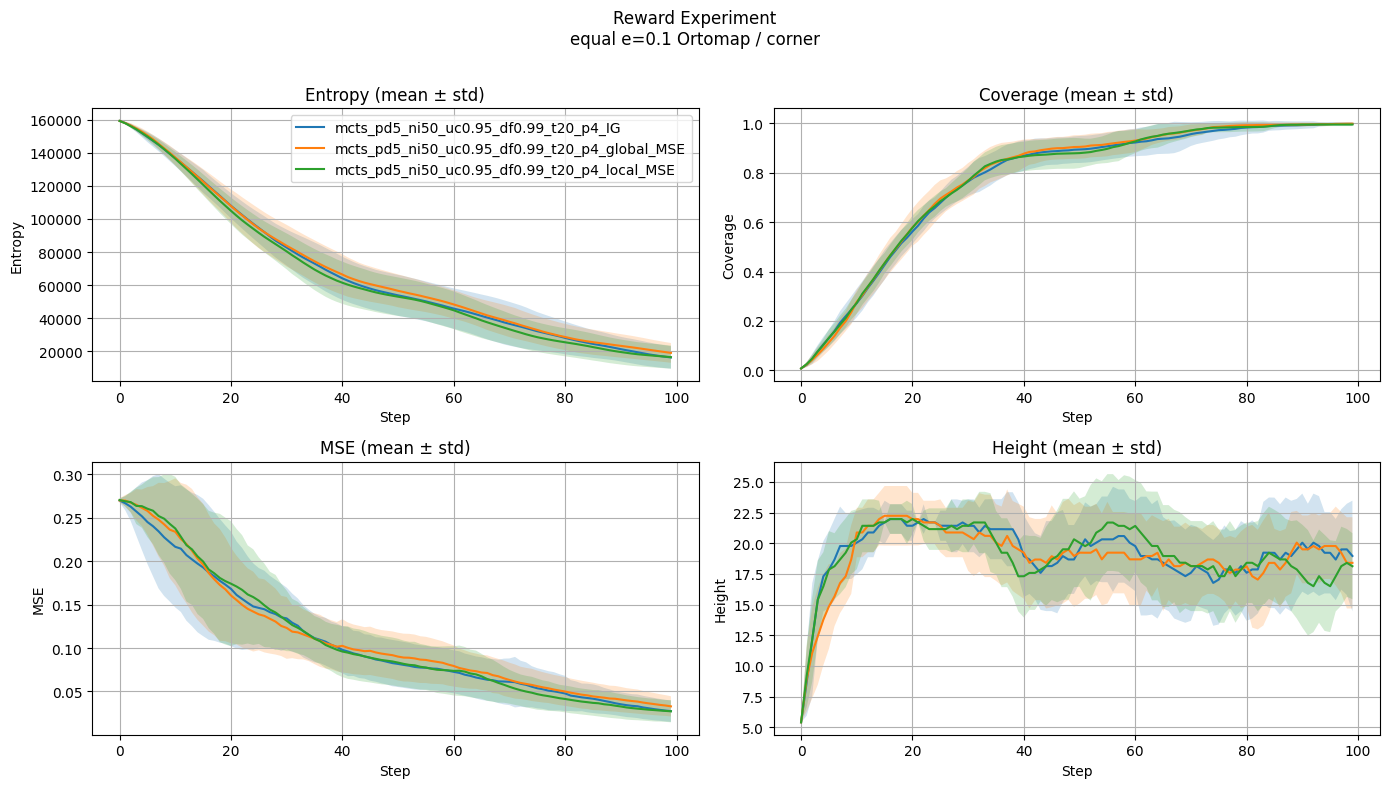

In [ ]:
plot_runs(df_reward_exp, title_suffix="Reward Experiment")

## Border compensation experiment


In [ ]:
exp_suffix = [
    "gaussian_edge_IG_border_comp",
    "gaussian_edge_IG_wout_border_comp",
    "gaussian_edge_MCTS_border_comp",
    "gaussian_edge_MCTS_wout_border_comp",
    "ortomap_edge_MCTS_border_comp",
    "ortomap_edge_IG_border_comp",
    "ortomap_edge_IG_wout_border_comp",
    "ortomap_edge_MCTS_wout_border_comp",
]
# Border compensation experiment
scr_trials = "/home/bota/Desktop/active_sensing_extended_planner/trials/"
# Build log paths for each experiment
border_log_paths = [
    Path(scr_trials) / suffix / "txt" / "run.log" for suffix in exp_suffix
]

# Collect records and add a 'setting_id' column based on exp_suffix
border_records = []
for suffix, log_path in zip(exp_suffix, border_log_paths):
    if log_path.exists():
        recs = collect_all_records([str(log_path)])
        for r in recs:
            r["setting_id"] = suffix  # override/add setting_id
        border_records.extend(recs)
    else:
        print(f"Log not found: {log_path}")

df_border = pd.DataFrame.from_records(border_records)
if not df_border.empty:
    # Aggregate using the custom setting_id
    # NOTE: aggregate_runs() recomputes setting_id using canonical_label, overwriting your suffix!
    # To preserve your custom setting_id, you must NOT call aggregate_runs, but aggregate manually.
    key_cols = [
        "field_type",
        "start_position",
        "pairwise",
        "strategy",
        "error_margin",
        "radius",
        "setting_id",  # use your custom setting_id
    ]
    agg_border = (
        df_border.groupby(key_cols + ["step"])
        .agg(
            entropy_mean=("entropy", "mean"),
            entropy_std=("entropy", "std"),
            mse_mean=("mse", "mean"),
            mse_std=("mse", "std"),
            coverage_mean=("coverage", "mean"),
            coverage_std=("coverage", "std"),
            height_mean=("height", "mean"),
            height_std=("height", "std"),
        )
        .reset_index()
    )
else:
    agg_border = pd.DataFrame()
print(agg_border["setting_id"].unique())

['gaussian_edge_IG_border_comp' 'gaussian_edge_IG_wout_border_comp'
 'gaussian_edge_MCTS_border_comp' 'gaussian_edge_MCTS_wout_border_comp'
 'ortomap_edge_IG_border_comp' 'ortomap_edge_IG_wout_border_comp'
 'ortomap_edge_MCTS_border_comp' 'ortomap_edge_MCTS_wout_border_comp']


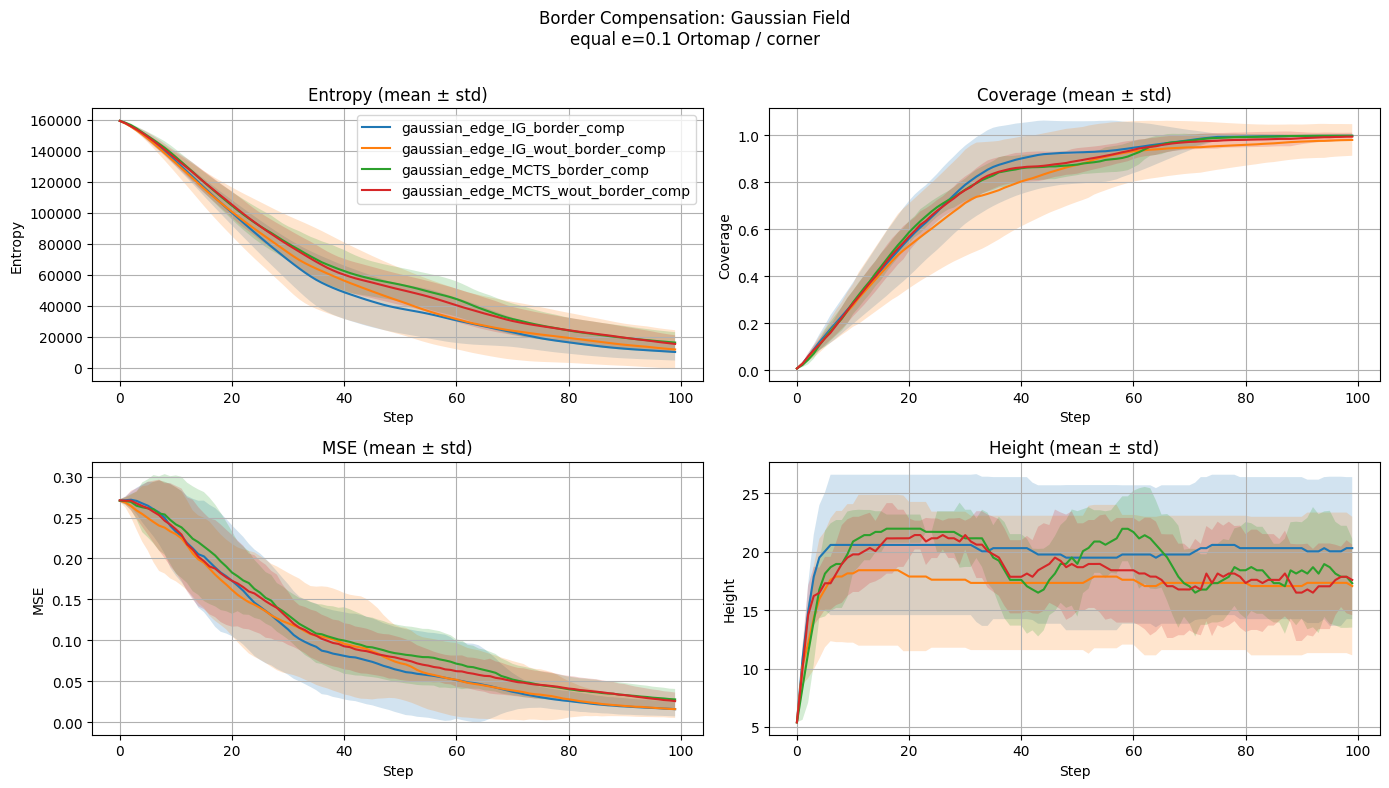

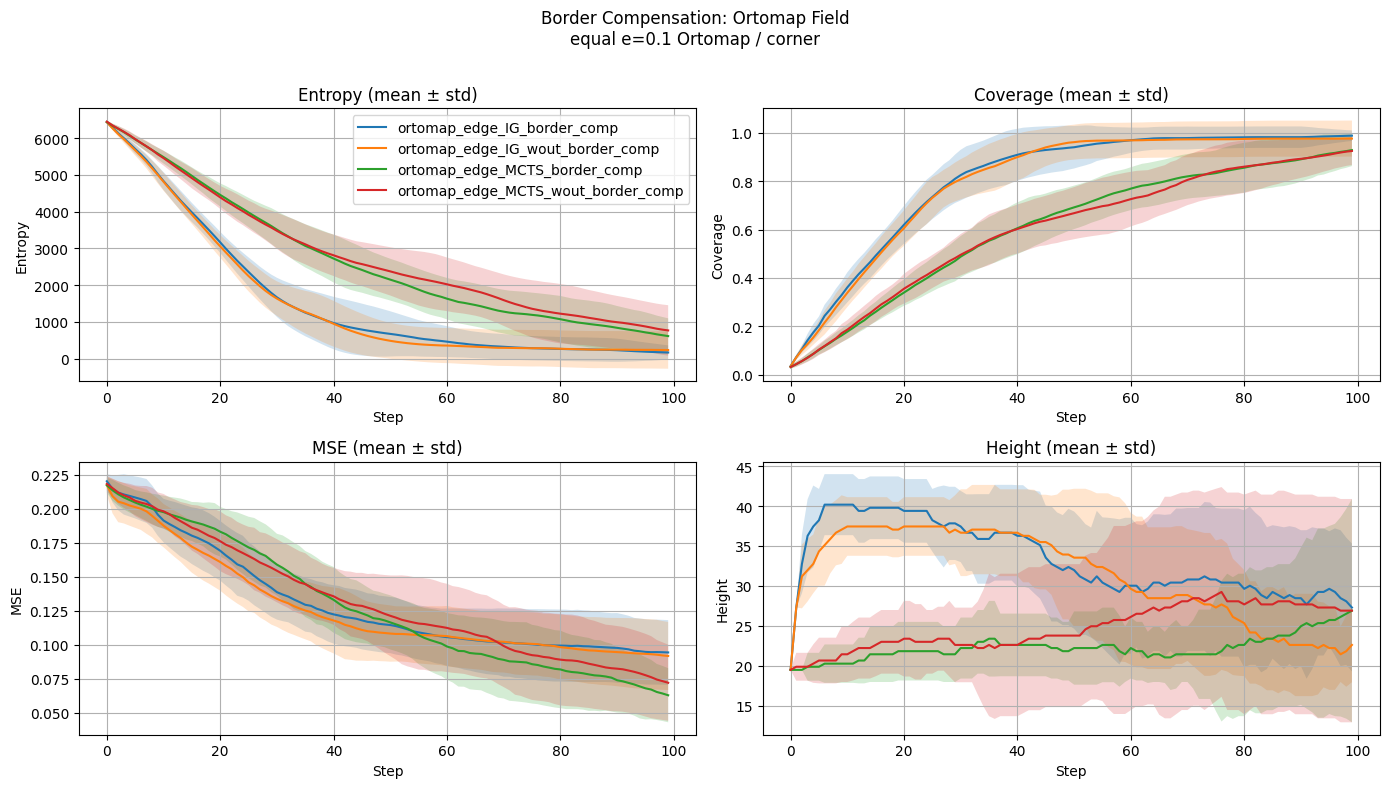

In [ ]:
# Plot only Gaussian field
plot_runs(
    agg_border[agg_border.field_type == "Gaussian"],
    title_suffix="Border Compensation: Gaussian Field",
)

# Plot only Ortomap field
plot_runs(
    agg_border[agg_border.field_type == "Ortomap"],
    title_suffix="Border Compensation: Ortomap Field",
)

## MCTS variation


In [13]:
exp_suffix = [
    "ortomap_edge_IG_wout_border_comp",
    "ortomap_edge_MCTS_sample_obs_most_rewarded",
    "ortomap_edge_MCTS_expd_obs_most_visited",
    "ortomap_edge_MCTS_sample_obs_most_visited",
    "gaussian_edge_IG_wout_border_comp",
    "gaussian_edge_MCTS_sample_obs_most_rewarded",
    "gaussian_edge_MCTS_expd_obs_most_visited",
    "gaussian_edge_MCTS_sample_obs_most_visited",
]
scr_trials = "/home/bota/Desktop/active_sensing_extended_planner/trials/"
mcts_var_log_paths = [
    Path(scr_trials) / suffix / "txt" / "run.log" for suffix in exp_suffix
]

# Collect records and add a 'setting_id' column based on exp_suffix
mctsvar_records = []
for suffix, log_path in zip(exp_suffix, mcts_var_log_paths):
    if log_path.exists():
        recs = collect_all_records([str(log_path)])
        for r in recs:
            r["setting_id"] = suffix  # override/add setting_id
        mctsvar_records.extend(recs)
    else:
        print(f"Log not found: {log_path}")
df_mctsvar = pd.DataFrame.from_records(mctsvar_records)

In [14]:
if not df_mctsvar.empty:
    # Aggregate using the custom setting_id
    # NOTE: aggregate_runs() recomputes setting_id using canonical_label, overwriting your suffix!
    # To preserve your custom setting_id, you must NOT call aggregate_runs, but aggregate manually.
    key_cols = [
        "field_type",
        "start_position",
        "pairwise",
        "strategy",
        "error_margin",
        "radius",
        "setting_id",  # use your custom setting_id
    ]
    agg_mctsvar = (
        df_mctsvar.groupby(key_cols + ["step"])
        .agg(
            entropy_mean=("entropy", "mean"),
            entropy_std=("entropy", "std"),
            mse_mean=("mse", "mean"),
            mse_std=("mse", "std"),
            coverage_mean=("coverage", "mean"),
            coverage_std=("coverage", "std"),
            height_mean=("height", "mean"),
            height_std=("height", "std"),
        )
        .reset_index()
    )
else:
    agg_mctsvar = pd.DataFrame()
print(agg_mctsvar["setting_id"].unique())

['gaussian_edge_IG_wout_border_comp'
 'gaussian_edge_MCTS_expd_obs_most_visited'
 'gaussian_edge_MCTS_sample_obs_most_rewarded'
 'gaussian_edge_MCTS_sample_obs_most_visited'
 'ortomap_edge_IG_wout_border_comp'
 'ortomap_edge_MCTS_expd_obs_most_visited'
 'ortomap_edge_MCTS_sample_obs_most_rewarded'
 'ortomap_edge_MCTS_sample_obs_most_visited']


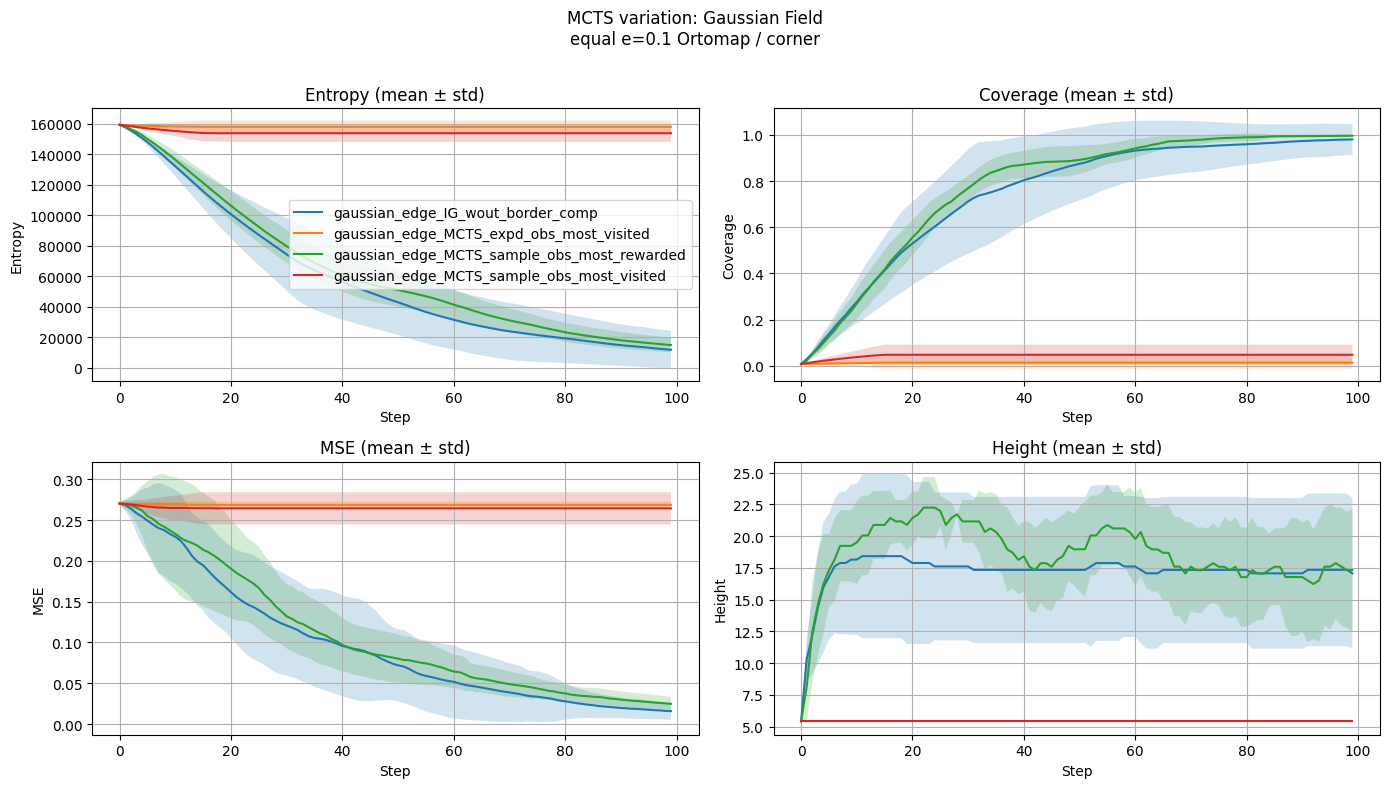

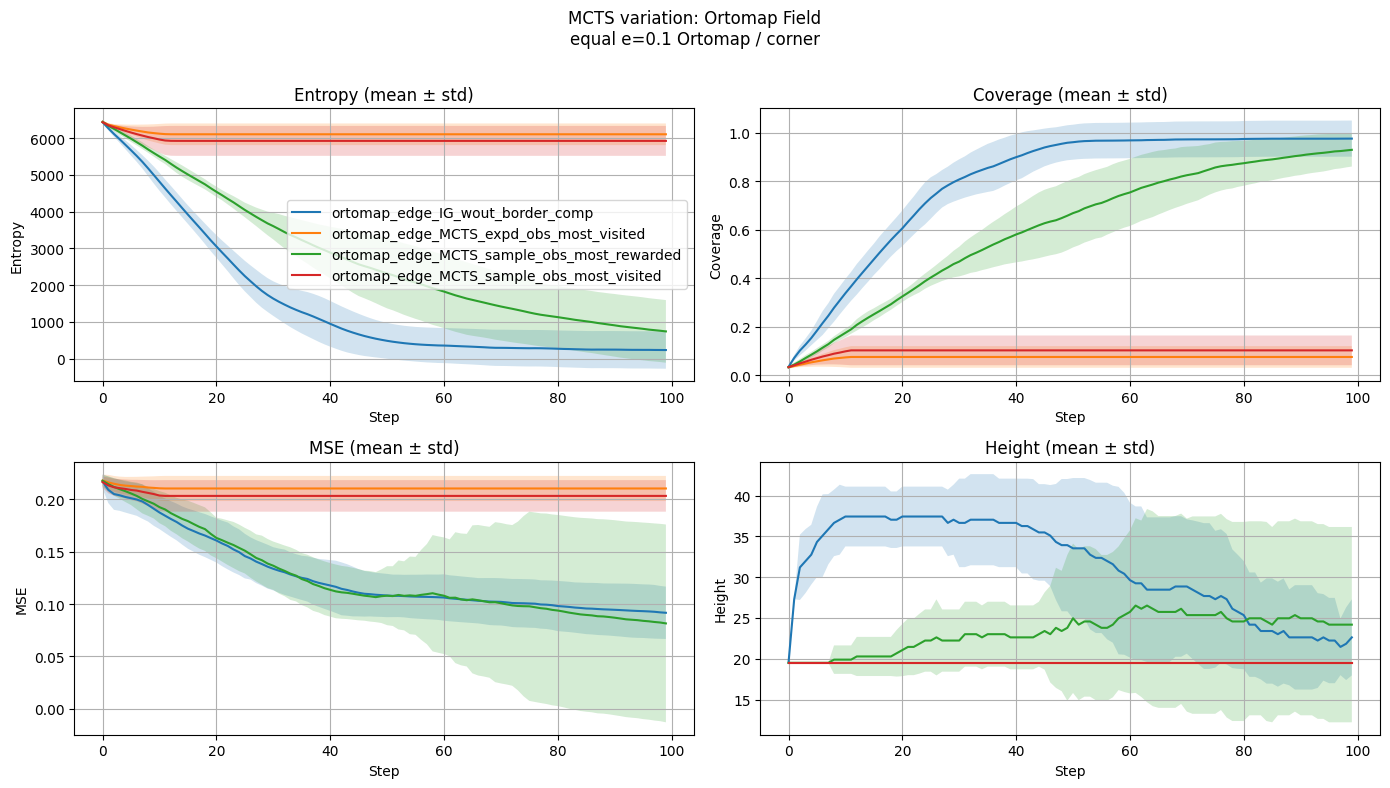

In [15]:
# Plot only Gaussian field
plot_runs(
    agg_mctsvar[agg_mctsvar.field_type == "Gaussian"],
    title_suffix="MCTS variation: Gaussian Field",
)

# Plot only Ortomap field
plot_runs(
    agg_mctsvar[agg_mctsvar.field_type == "Ortomap"],
    title_suffix="MCTS variation: Ortomap Field",
)

## Conf
